### ***Research Example - DeepBind (2015)***
# **Building the DeepBind model through a pytorch framework (CPU)**

## **1. Preprocess**
### 1.1. Load the raw data of ***ALX homeobox protein 1*** (SELEX sequencing data) 
- references 
    - http://tools.genes.toronto.edu/deepbind/D00289.002/index.html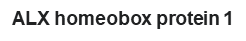
    - https://github.com/MedChaabane/DeepBind-with-PyTorch
- download 
    - [Training raw dataset](https://1drv.ms/u/s!AljTCh5CK9KvgYltlkAVHPv7kbdytg?e=qBtIgu) 
    - [Testing raw dataset](https://1drv.ms/u/s!AljTCh5CK9KvgYlsgGwcmTp5L-35iQ?e=k8eUxH) 

In [1]:
from collections import defaultdict
import numpy as np

def raw_seq_parser(path):
    f = open(path, "r")
    seqs = []
    seq_lens = []
    labels = []
    flines = f.readlines()
    cols = None
    for i, line in enumerate(flines):
        if not i :
            cols = line.replace("\n","").split("\t")
        else:
            fold_id, event_id, seq, bound = line.replace("\n","").split("\t")
            seqs.append(seq)
            labels.append(int(bound))
            seq_lens.append(len(seq))
            
    num_pos = sum(labels)
    num_neg = len(labels) - num_pos
    print("Load {} finish ({} lines, #positive: {}, #negative: {})".format(path, len(labels), num_pos, num_neg))
    print("- sequence sizes : {}".format(set(seq_lens)))
    
    return seqs, labels


# path of raw data
TRAIN_RAW = "Alx1_DBD_TAAAGC20NCG_3_Z_B.seq"
TEST_RAW  = "Alx1_DBD_TAAAGC20NCG_3_Z_A.seq"
    
train_seqs, y = raw_seq_parser(TRAIN_RAW)
test_seqs, test_y = raw_seq_parser(TEST_RAW)

Load Alx1_DBD_TAAAGC20NCG_3_Z_B.seq finish (255508 lines, #positive: 127754, #negative: 127754)
- sequence sizes : {20}
Load Alx1_DBD_TAAAGC20NCG_3_Z_A.seq finish (128012 lines, #positive: 128012, #negative: 0)
- sequence sizes : {20}


### 1.2. DNA sequence encoding + padding for motif detector + reverse-complement mode

- Baseline: one-hot encoding
- Due to the length of all sequences in the dataset is same (20bp), we don't need the encoding methods for variable length data
- **Padding the letter 'N' in front of an input sequence and the end too**
- When training a model on sequences derived from double-stranded DNA (PBM, SELEX, ChIP-seq), it is unknown whether the protein bound to the input strand or whether it bound to the opposite strand.

#### *(Supplimentary information in DeepBind 2015)*
<img src="figures/deepbind_supp_01.PNG" width="750px">

In [2]:
# ref [complement,reverse_complement] from [https://github.com/MedChaabane/DeepBind-with-PyTorch/]
def complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    complseq = [complement[base] for base in seq]
    return complseq
  
def reverse_complement(seq):
    seq = list(seq)
    seq.reverse()
    return ''.join(complement(seq))

def onehot_encoder_with_padding_and_reverse_complement(seqs, labels, letters="ACGT", motif_len=10):
    print("Original sequence length {}".format(len(seqs[0])))
    enc = defaultdict(lambda: np.array([1/len(letters)]*len(letters))) # default. [0.25,0.25,0.25,0.25]
    for i,l in enumerate(letters):
        f      = np.zeros(len(letters))
        f[i]   = 1
        enc[l] = f
    
    # reverse-complement (note that it have to apply for DNA seqs)
    _seqs = []
    _labels = []
    for seq, label in zip(seqs, labels):
        _seqs.append(seq)
        _labels.append([label])
        _seqs.append(reverse_complement(seq))
        _labels.append([label])
    
    seqs = _seqs
    labels = _labels
    
    # one-hot encoding
    onehot_features = []
    for seq in seqs:
        # Append padding letter 'N' accoding to the <length of motif-1>
        seq = 'N' * (motif_len-1) + seq + 'N' * (motif_len-1)
        feature = []
        for c in seq.upper():
            feature.append(enc[c])
        onehot_features.append(feature)
        
    onehot_features = np.array(onehot_features)
    print("One-hot encoding finished, with feature shape {}".format(onehot_features.shape))
    return onehot_features, labels

LEN_MOTIF      = 10
X, y           = onehot_encoder_with_padding_and_reverse_complement(train_seqs, y, motif_len=LEN_MOTIF)
test_x, test_y = onehot_encoder_with_padding_and_reverse_complement(test_seqs, test_y, motif_len=LEN_MOTIF)

Original sequence length 20
One-hot encoding finished, with feature shape (511016, 38, 4)
Original sequence length 20
One-hot encoding finished, with feature shape (256024, 38, 4)


### 1.3. Split Train & Valid dataset 
- The testset has only positive class
- Most evaluation metrices of binary classification problem need negative class
- We split the training set to train and valid datasets
- The testset only used when the model training is finished

In [3]:
from sklearn.model_selection import train_test_split

X, y = np.array(X), np.array(y) # convert python-list to numpy-array

train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.33, # ratio of size of train-test set splitting
                                                      random_state=42) # random-seed

print("Train set | x: {}, y: {} \nValid set | x: {}, y: {}".format(train_x.shape,
                                                                   train_y.shape,
                                                                   valid_x.shape,
                                                                   valid_y.shape))

Train set | x: (342380, 38, 4), y: (342380, 1) 
Valid set | x: (168636, 38, 4), y: (168636, 1)


In [4]:
train_x = train_x.reshape(-1, 4, 38)[:5000]
valid_x = valid_x.reshape(-1, 4, 38)[:500]
test_x  = test_x.reshape(-1, 4, 38)[:100]

train_y = np.array(train_y[:5000])
valid_y = np.array(valid_y[:500])
test_y  = np.array(test_y[:100])

print(train_x.shape, valid_x.shape, test_x.shape)
print(train_y.shape, valid_y.shape, test_y.shape)

(5000, 4, 38) (500, 4, 38) (100, 4, 38)
(5000, 1) (500, 1) (100, 1)


## **2. 1D-Convolutional Neural Network for binary classification (pytorch)**
### 2.1. Initialization of CNN-Model
<img src="figures/deepbind_supp_02.PNG" width="750">

#### *Convolution*
- The defining feature of any ConvNet is that it begins with at least one convolution stage. 
- In the context of genomic sequences, a 1-dimensional convolution over a 4-channel input can play the same role as a “motif scan” operation in a PWM or PSAM-based model.

#### *Rectification*
- We call this a rectified motif scan.
- In neural network terminology, this simple nonlinear operation is known as a rectified linear unit (ReLU) layer

#### *Pooling*
- We implemented two choices for the pooling stage: **“max pooling”**, or **“max pooling and average pooling.”**

#### *Neural network*
- We allow the choice of either **“no hidden layer”** or **“one hidden layer with 32 rectified-linear units”** ...
- In this example, only **“no hidden layer”** will be implemented.
- Do not cover the dropout part of DeepBind too

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cpu'

In [6]:
class ConvNet(nn.Module):
    def __init__(self, num_motifs, len_motif, pooling_type="max"): # pool_type = [max, maxavg]
        super(ConvNet, self).__init__()
        self.l_conv = nn.Conv1d(in_channels  = 4, 
                                out_channels = num_motifs,
                                kernel_size  = len_motif,
                                stride       = 1, 
                                padding      = 0)
        
        self.pooling_type = pooling_type
        self.relu = nn.ReLU()
        if pooling_type == "max":
            self.l_nnet = nn.Linear(num_motifs,1) 
        else:
            self.l_nnet = nn.Linear(num_motifs*2,1)
            
        print("- Motif scanners : {}".format(self.l_conv.weight.size()))
        
    def get_motif_scanners(self):
        return self.l_conv.weight
    
    def get_rectified_motif_scan(self, x):
        x = self.l_conv(x)
        x = self.relu(x)
        return x
    
    def forward_test(self, x):
        print("- Input shape    : {}".format(x.size()))
        x = self.relu(self.l_conv(x))
        print("- After 1d-conv  : {}".format(x.size()))
        m , _ = torch.max(x,dim=2)
        if self.pooling_type == "maxavg":
            a = torch.mean(x, dim=2)
            x = torch.cat((m,a), dim=1)
        else:
            x = m
        print("- After max-pool : {}".format(x.size()))
        logit = self.l_nnet(x)
        y = torch.sigmoid(logit)
        print("- After fc-net   : {}".format(y.size()))
        return y
    
    def forward(self, x):
        x = self.l_conv(x)
        x = self.relu(x)
        m , _ = torch.max(x,dim=2)
        if self.pooling_type == "maxavg":
            a = torch.mean(x, dim=2)
            x = torch.cat((m,a), dim=1)
        else:
            x = m
        logit = self.l_nnet(x)
        y = torch.sigmoid(logit)
        return y
    
NUM_MOTIFS = 16
convnet = ConvNet(num_motifs   = NUM_MOTIFS, 
                  len_motif    = LEN_MOTIF,
                  pooling_type = "maxavg")
output  = convnet.forward_test(torch.randn(10, 4, 38))  # (num_seq, num_in_chn, len_seq)

- Motif scanners : torch.Size([16, 4, 10])
- Input shape    : torch.Size([10, 4, 38])
- After 1d-conv  : torch.Size([10, 16, 29])
- After max-pool : torch.Size([10, 32])
- After fc-net   : torch.Size([10, 1])


### 2.2. Initialization of model trainings

In [7]:
import torch.optim as optim
from sklearn import datasets, metrics
epochs = 50
batch_size = 32
learning_rate = 0.01
criterion = torch.nn.BCELoss()
optimizer = optim.SGD(convnet.parameters(), lr=learning_rate)
print(criterion)
print(optimizer)

BCELoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [8]:
# numpy array to tensor
ts_train_x = torch.tensor(train_x, dtype=torch.float32)
ts_train_y = torch.tensor(train_y, dtype=torch.float32)
ts_valid_x = torch.tensor(valid_x, dtype=torch.float32)
ts_valid_y = torch.tensor(valid_y, dtype=torch.float32)
ts_test_x  = torch.tensor(test_x, dtype=torch.float32)
ts_test_y  = torch.tensor(test_y, dtype=torch.float32)
print(ts_train_x.size(), ts_train_y.size())
print(ts_valid_x.size(), ts_valid_y.size())
print(ts_test_x.size(), ts_test_y.size())

torch.Size([5000, 4, 38]) torch.Size([5000, 1])
torch.Size([500, 4, 38]) torch.Size([500, 1])
torch.Size([100, 4, 38]) torch.Size([100, 1])


In [9]:
train_data = [(_x,_y) for _x, _y in zip(ts_train_x, ts_train_y)]
valid_data = [(_x,_y) for _x, _y in zip(ts_valid_x, ts_valid_y)]
test_data  = [(_x,_y) for _x, _y in zip(ts_test_x, ts_test_y)]

In [10]:
train_loader = torch.utils.data.DataLoader(dataset    = train_data, 
                                           batch_size = batch_size, 
                                           shuffle    = True)

valid_loader = torch.utils.data.DataLoader(dataset    = valid_data,
                                           batch_size = batch_size,
                                           shuffle    = True)

test_loader  = torch.utils.data.DataLoader(dataset    = test_data,
                                           batch_size = batch_size,
                                           shuffle    = True)

### 2.3. Training & Validation

In [11]:
convnet.to(device)

ConvNet(
  (l_conv): Conv1d(4, 16, kernel_size=(10,), stride=(1,))
  (relu): ReLU()
  (l_nnet): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
convnet.train()
for epoch in range(epochs):
    # Training
    train_loss = []
    for index, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = convnet(data)
        loss   = criterion(output, target)
        loss.backward()  
        optimizer.step()
        train_loss.append(loss.item())
    
    # Validation
    valid_output = convnet(ts_valid_x.to(device))
    valid_loss = criterion(valid_output.to(device), ts_valid_y.to(device))
    valid_loss = valid_loss.item()
    valid_roc_auc = metrics.roc_auc_score(ts_valid_y.detach().numpy(),
                                          valid_output.detach().numpy())
    
    print("Epoch {:>6} | Train Loss {:.5f} | Valid Loss {:.5f} | Valid ROC-AUC {:.5f}".format(epoch, 
                                                                                              np.mean(train_loss),
                                                                                              valid_loss, 
                                                                                              valid_roc_auc))

Epoch      0 | Train Loss 0.69468 | Valid Loss 0.69229 | Valid ROC-AUC 0.53266
Epoch      1 | Train Loss 0.69256 | Valid Loss 0.69213 | Valid ROC-AUC 0.55947
Epoch      2 | Train Loss 0.69177 | Valid Loss 0.69163 | Valid ROC-AUC 0.58689
Epoch      3 | Train Loss 0.69089 | Valid Loss 0.69094 | Valid ROC-AUC 0.61325
Epoch      4 | Train Loss 0.68986 | Valid Loss 0.68982 | Valid ROC-AUC 0.63683
Epoch      5 | Train Loss 0.68874 | Valid Loss 0.68847 | Valid ROC-AUC 0.65648
Epoch      6 | Train Loss 0.68730 | Valid Loss 0.68792 | Valid ROC-AUC 0.67073
Epoch      7 | Train Loss 0.68558 | Valid Loss 0.68614 | Valid ROC-AUC 0.68116
Epoch      8 | Train Loss 0.68371 | Valid Loss 0.68460 | Valid ROC-AUC 0.68763
Epoch      9 | Train Loss 0.68166 | Valid Loss 0.68261 | Valid ROC-AUC 0.69271
Epoch     10 | Train Loss 0.67893 | Valid Loss 0.68032 | Valid ROC-AUC 0.69676
Epoch     11 | Train Loss 0.67594 | Valid Loss 0.67781 | Valid ROC-AUC 0.70070
Epoch     12 | Train Loss 0.67256 | Valid Loss 0.674

### 2.4. Test the model

In [13]:
# Testing
test_output = convnet(ts_test_x.to(device)).detach().numpy()
test_output = test_output > 0.5
print(metrics.classification_report(test_y, test_output))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.71      0.83       100

    accuracy                           0.71       100
   macro avg       0.50      0.35      0.42       100
weighted avg       1.00      0.71      0.83       100



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **3. Visualizations for DeepBind models**
### 3.1. Mutation Map

In [14]:
# PASS

### 3.2. Sequence Logos
To visualize the pattern learned by a particular DeepBind motif detector $𝑀_𝑘$, we generate a PWM derived from the detector’s response to actual sequences.

1. We feed all sequences from the test set (foreground and background) through the convolutional and rectification stages of the DeepBind model
2. We align all the sequences that passed the activation threshold
3. Once the sequences are aligned, we generate a position frequency matrix (PFM)
4. Transform it into a sequence logo in the standard way

In [15]:
# < Position Frequency Matrix using DeepBind model >
# 
# 1. Get rectified motif scan result (from model) from the test dataset sequences
# 2. For each motif, find maximum valued position (j)
# 3. Extract subsequence from input sequence where (j-m+1) ~ (j)
# 3-1 when the positions (j-m+1) ~ (j) beyond the sequence range, fill the empty (letter N)
# 4. Accumulate all subsequences (length m) and count letter of each position

def get_subsequence(seq_x, start, end, letters="ACGT"):
    ret = ""
    ldict = {i:l for i,l in enumerate(letters)}
    if start < 0:
        ret = "N"*(-start) + ret
        for i in range(end):
            x = seq_x[:, i]
            base = ldict[np.argmax(x)]
            ret = ret + base
    else:
        for i in range(start, end):
            x = seq_x[:, i]
            base = ldict[np.argmax(x)]
            ret = ret + base
    
    return ret

# Check the global parameters
print(LEN_MOTIF, convnet)
print("Test input sequences for extracting motif {}".format(ts_test_x.shape))

# 1. Get rectified motif scan result (from model) from the test dataset sequences
rect_scans = convnet.get_rectified_motif_scan(ts_test_x.to(device)).detach().numpy() 
print("Returned rectified motif scan data {}".format(rect_scans.shape))

# 4. Accumulate all subsequences (length m) and count letter of each position
test_subseqs_list = []

for test_seq, rect_scan in zip(ts_test_x, rect_scans):    
    test_subseqs = []
    test_seq = test_seq.detach().numpy()
    
    for m_i, m_scans in enumerate(rect_scan):
        # 2. For each motif, find maximum valued position (j)
        j = np.argmax(m_scans)
        j_m_1 = j - LEN_MOTIF + 1
        
        # 3. Extract subsequence from input sequence where (j-m+1) ~ (j)
        # 3-1 when the positions (j-m+1) ~ (j) beyond the sequence range, fill the empty (letter N)
        subseq = get_subsequence(test_seq, j_m_1, j+1)
        
        # print(m_i+1, j_m_1, j, subseq, len(subseq))
        test_subseqs.append(subseq)
        
    test_subseqs_list.append(test_subseqs)

10 ConvNet(
  (l_conv): Conv1d(4, 16, kernel_size=(10,), stride=(1,))
  (relu): ReLU()
  (l_nnet): Linear(in_features=32, out_features=1, bias=True)
)
Test input sequences for extracting motif torch.Size([100, 4, 38])
Returned rectified motif scan data (100, 16, 29)


In [19]:
test_subseqs_list[10]

['GCACAAACAA',
 'NNNNNNNNGC',
 'NNGCACAAAC',
 'CAAACAACAA',
 'ACAACAAACA',
 'ACAACGAAAG',
 'CGAAAGCAAA',
 'ACAAACAACG',
 'NNNNNNNGCA',
 'AAACAACAAA',
 'AAAGCAAACA',
 'NGCACAAACA',
 'NNNNNNGCAC',
 'GCACAAACAA',
 'CAAACAACAA',
 'NNNNNNNNNG']